In [1]:
#importation des packages

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random
import pyarrow
import statsmodels.api as sm

In [11]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
#Choix des options

#Lien pour les données
#data_path=""
#data_path="Données/"
data_path="Données/"

In [3]:
from utility_tools import regroupement_data

data_hour_wind,data_day_wind=regroupement_data(data_path+'Data_Toulouse/Wind_power_default/',1980,2022)

print(data_hour_wind.head(),data_hour_wind.tail(),data_day_wind.head(),data_day_wind.tail())
#print(data_day_wind.dtypes)

Toutes les données sont différentes
                 time        local_time  electricity  wind_speed
0 1980-01-01 00:00:00  1980-01-01 01:00        0.132       5.062
1 1980-01-01 01:00:00  1980-01-01 02:00        0.108       4.756
2 1980-01-01 02:00:00  1980-01-01 03:00        0.107       4.753
3 1980-01-01 03:00:00  1980-01-01 04:00        0.086       4.448
4 1980-01-01 04:00:00  1980-01-01 05:00        0.085       4.439                     time        local_time  electricity  wind_speed
8755 2022-12-31 19:00:00  2022-12-31 20:00        0.429       7.650
8756 2022-12-31 20:00:00  2022-12-31 21:00        0.422       7.603
8757 2022-12-31 21:00:00  2022-12-31 22:00        0.420       7.593
8758 2022-12-31 22:00:00  2022-12-31 23:00        0.426       7.632
8759 2022-12-31 23:00:00  2023-01-01 00:00        0.423       7.613             electricity  wind_speed
time                               
1980-01-01     0.274292    6.263542
1980-01-02     0.334875    6.864042
1980-01-03     0.02370

In [5]:
# On commence par regrouper les données par année
data_hour_copy=data_hour_wind.copy()
data_hour_copy['day']=data_hour_copy['time'].dt.day
data_hour_copy['month']=data_hour_copy['time'].dt.month

data_year_wind_tendance = data_hour_copy.groupby(['month', 'day']).agg({'electricity': 'mean', 'wind_speed': 'mean'})

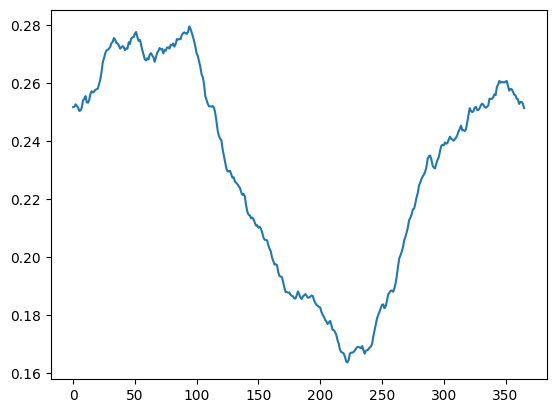

In [6]:
serie = (pd.concat([data_year_wind_tendance['electricity'][338:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:28]]).rolling(28, center=True).mean().to_numpy()[28:394])
plt.plot(serie)

C:\Users\Manon Julia\AppData\Local\Temp\ipykernel_37100\445893444.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_day_season['electricity'][int(0.75+i*365.25):int(0.75+(i+1)*365.25)]=data_day_season['electricity'][int(0.75+i*365.25

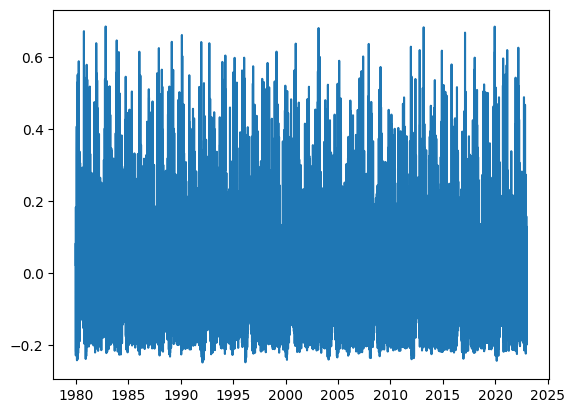

In [8]:
#Mise en forme des données

#Etant donné qu'on a pas soustrait la tendance pour calculer la saisonnalité jusqu'à maintenant, car on prend une tendance constante, je vais juste retirer la saisonnalité.


#On initialise les données
saison28=pd.concat([data_year_wind_tendance['electricity'][338:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:28]]).rolling(28, center=True).mean().to_numpy()[28:394]

data_day_season=data_day_wind.copy()
bissextile=4

for i in range(43): #On parcourt nos 43 années de données
    
    if bissextile == 4 : #Si année bissextile
        tend=saison28
        bissextile=0
    else:
        tend=saison28[~59]
        
    #print(1980+i,int(0.75+i*365.25),int(0.75+(i+1)*365.25))
    data_day_season['electricity'][int(0.75+i*365.25):int(0.75+(i+1)*365.25)]=data_day_season['electricity'][int(0.75+i*365.25):int(0.75+(i+1)*365.25)]-tend
    
    bissextile += 1

    
plt.plot(data_day_season['electricity'])

In [9]:
serie_ = data_day_season['electricity']

In [12]:
arma = ARIMA(serie_, order=(1,0,3)).fit() # p=1 et q=3

arma.summary()

c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            electricity   No. Observations:                15706
Model:                 ARIMA(1, 0, 3)   Log Likelihood                8587.351
Date:                Tue, 12 Mar 2024   AIC                         -17162.701
Time:                        10:58:23   BIC                         -17116.730
Sample:                    01-01-1980   HQIC                        -17147.483
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0083      0.004     -2.094      0.036      -0.016      -0.001
ar.L1          0.9646      0.007    132.194      0.000       0.950       0.979
ma.L1         -0.4949      0.010    -48.381      0.000      -0.515      -0.475
ma.L2         -0.3050      0.009    -35.629      0.000      -0.322      -0.288
ma.L3         -0.1002      0.008    -12.987      0.000      -0.115      -0.085
sigma2         0.0196      0.000     91.537      0.000       0.019       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2772.02
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.90
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

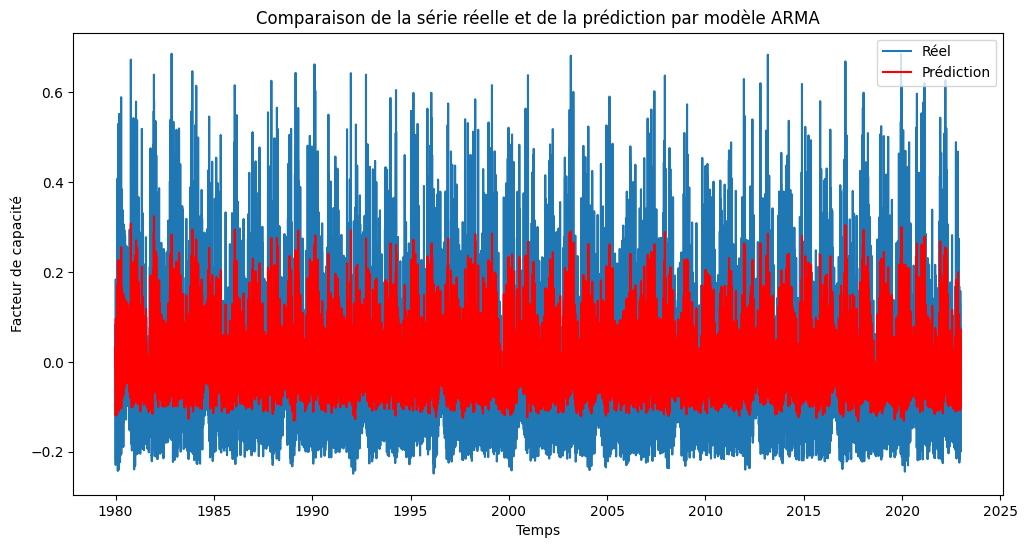

In [13]:
pred = arma.predict()

plt.figure(figsize=(12,6))
plt.plot(serie_,label="Réel")
plt.plot(pred, color = "r",label="Prédiction")
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()

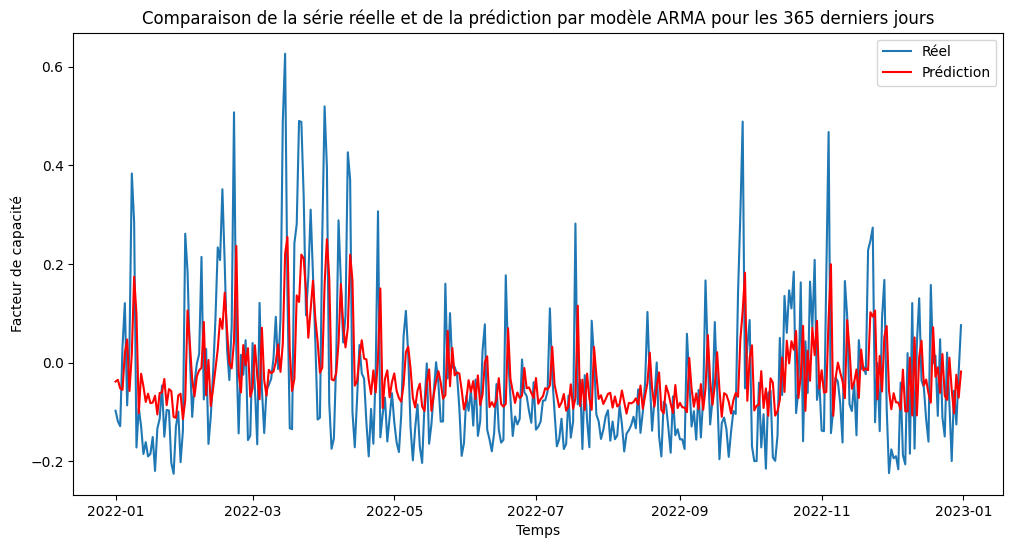

In [14]:
# Sélection des 365 derniers jours pour chaque série
serie_derniere_annee = serie_[-365:]
pred_derniere_annee = pred[-365:]

# Création du graphique
plt.figure(figsize=(12,6))

# Affichage de la série réelle pour les 365 derniers jours
plt.plot(serie_derniere_annee, label="Réel")

# Affichage de la prédiction pour les 365 derniers jours
plt.plot(pred_derniere_annee, color = "r", label="Prédiction")

# Ajout des légendes et titres
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA pour les 365 derniers jours")
plt.legend()

# Affichage du graphique
plt.show()

In [15]:
type(pred)

pandas.core.series.Series

In [17]:
pred.shape

(15706,)

# Découpage des données

In [18]:
# On fait 5 paquets, le premier paquet sera celui de test et les autres ceux de train
# 4 paquets de 3141 et 1 paquet de 3142

c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


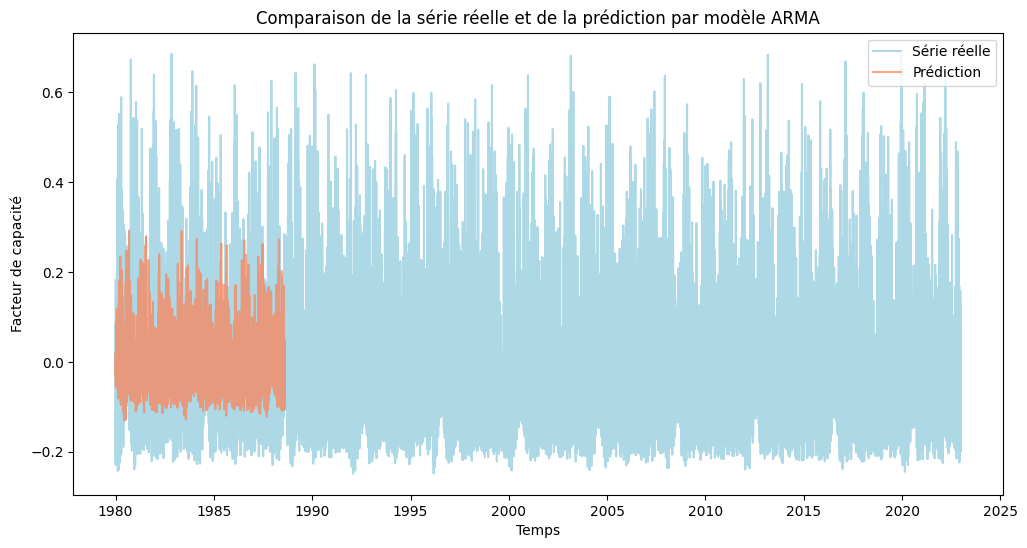

In [46]:
serie_test1 = serie_.iloc[:3143]
serie_train1 = serie_.iloc[3143:]

# Création et ajustement du modèle ARMA
arma1 = ARIMA(serie_train1, order=(1,0,3)).fit()

# Prédiction sur la série de test
pred1 = arma1.predict(start=1, end=len(serie_test1), dynamic=False)

# Ajustez l'index des prédictions pour qu'il corresponde à celui de serie_test
pred1.index = serie_test1.index

# Affichage
plt.figure(figsize=(12,6))
plt.plot(serie_, color="lightblue", label="Série réelle")
plt.plot(pred1, color="coral", label="Prédiction", alpha=0.7) 

plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()


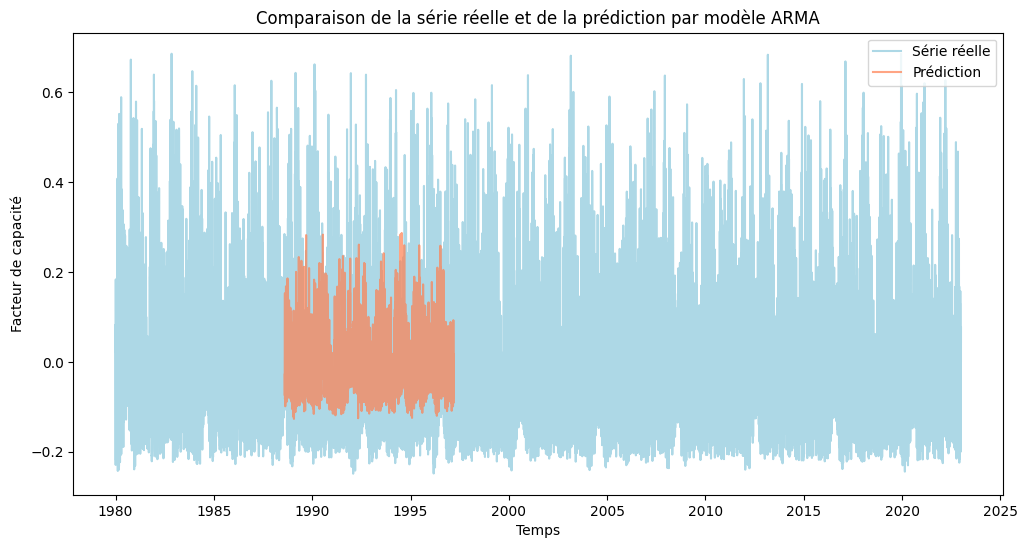

In [37]:
# Nouveau découpage
serie_train2 = pd.concat([serie_.iloc[:3143], serie_.iloc[6285:]])
serie_test2 = serie_.iloc[3143:6285]

serie_train2 = serie_train2.reset_index(drop=True)

# Création et ajustement du modèle ARMA
arma2 = ARIMA(serie_train2, order=(1,0,3)).fit()

# Le 'start' doit correspondre au premier index de la série de test
# 'end' doit être le dernier index de la série de test
pred2 = arma2.predict(start=3143, end=6284, dynamic=False)

# Ajustement de l'index des prédictions pour qu'il corresponde à celui de serie_test2
pred2.index = serie_test2.index

# Affichage
plt.figure(figsize=(12,6))
plt.plot(serie_, color="lightblue", label="Série réelle")
plt.plot(pred2, color="coral", label="Prédiction", alpha=0.7)

plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()

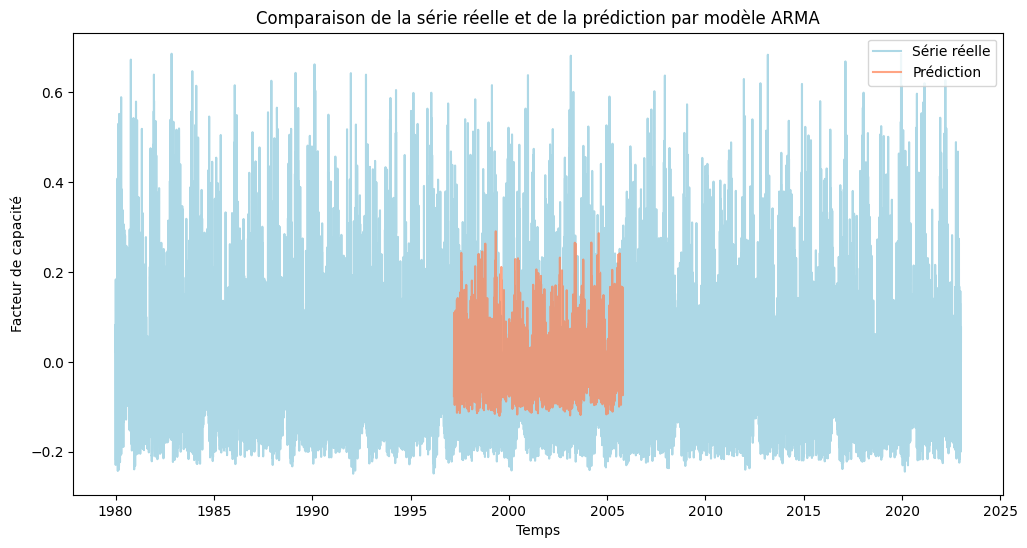

In [39]:
# Nouveau découpage
serie_train3 = pd.concat([serie_.iloc[:6285], serie_.iloc[9427:]])
serie_test3 = serie_.iloc[6285:9427]

serie_train3 = serie_train3.reset_index(drop=True)

# Création et ajustement du modèle ARMA
arma3 = ARIMA(serie_train3, order=(1,0,3)).fit()

# Le 'start' doit correspondre au premier index de la série de test
# 'end' doit être le dernier index de la série de test
pred3 = arma3.predict(start=6285, end=9426, dynamic=False)

# Ajustement de l'index des prédictions pour qu'il corresponde à celui de serie_test2
pred3.index = serie_test3.index

# Affichage
plt.figure(figsize=(12,6))
plt.plot(serie_, color="lightblue", label="Série réelle")
plt.plot(pred3, color="coral", label="Prédiction", alpha=0.7)

plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()

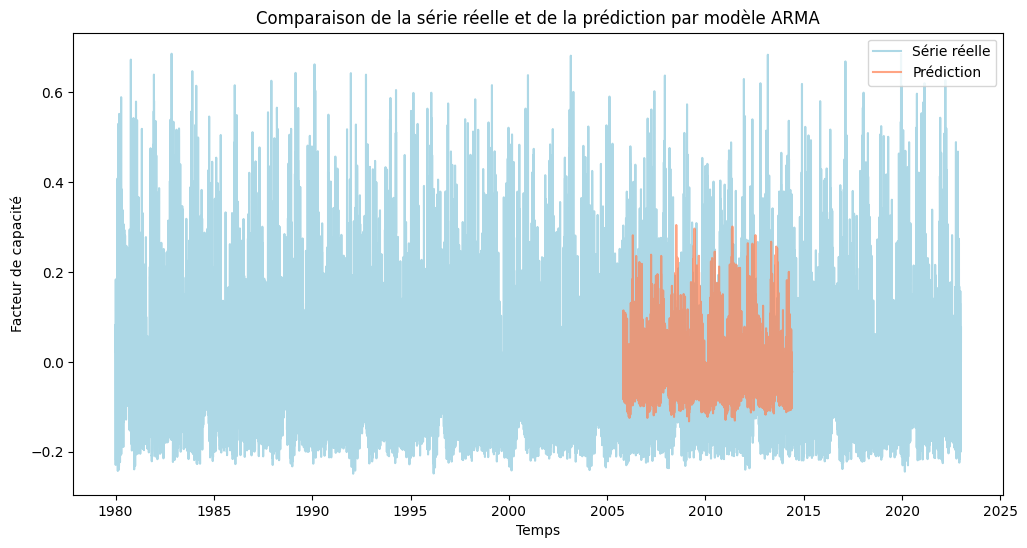

In [40]:
# Nouveau découpage
serie_train4 = pd.concat([serie_.iloc[:9427], serie_.iloc[12569:]])
serie_test4 = serie_.iloc[9427:12569]

serie_train4 = serie_train4.reset_index(drop=True)

# Création et ajustement du modèle ARMA
arma4 = ARIMA(serie_train4, order=(1,0,3)).fit()

# Le 'start' doit correspondre au premier index de la série de test
# 'end' doit être le dernier index de la série de test
pred4 = arma4.predict(start=9427, end=12568, dynamic=False)

# Ajustement de l'index des prédictions pour qu'il corresponde à celui de serie_test2
pred4.index = serie_test4.index

# Affichage
plt.figure(figsize=(12,6))
plt.plot(serie_, color="lightblue", label="Série réelle")
plt.plot(pred4, color="coral", label="Prédiction", alpha=0.7)

plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()

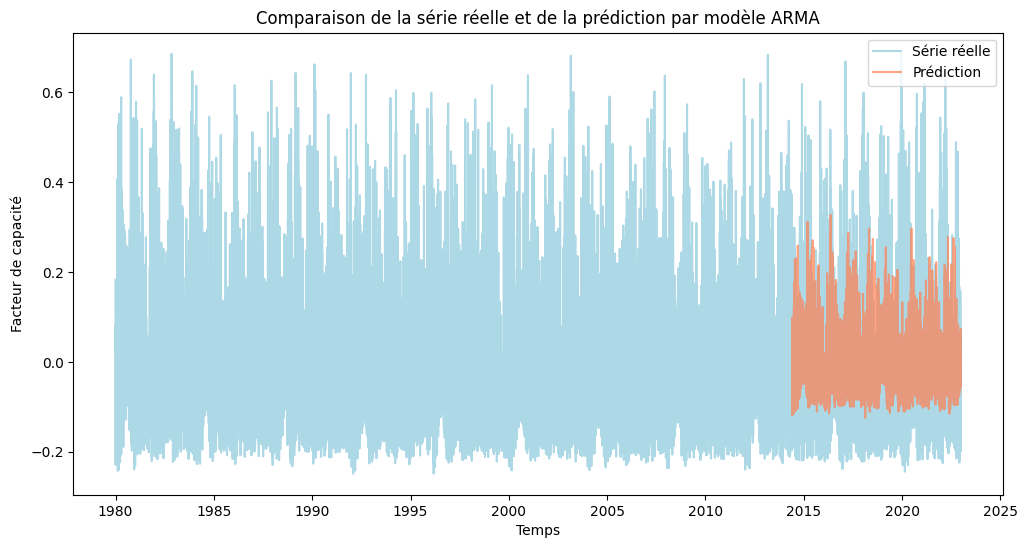

In [44]:
# Nouveau découpage
serie_train5 = serie_.iloc[:12569]
serie_test5 = serie_.iloc[12569:]

serie_train5 = serie_train5.reset_index(drop=True)

# Création et ajustement du modèle ARMA
arma5 = ARIMA(serie_train5, order=(1,0,3)).fit()

# Le 'start' doit être ajusté en fonction du nouvel index de serie_train5
# 'end' doit être le nombre de prédictions souhaitées
pred5 = arma5.predict(start=0, end=len(serie_test5)-1, dynamic=False) 

# Ajustement de l'index des prédictions pour qu'il corresponde à celui de serie_test5
pred5.index = serie_test5.index

# Affichage
plt.figure(figsize=(12,6))
plt.plot(serie_, color="lightblue", label="Série réelle")
plt.plot(pred5, color="coral", label="Prédiction", alpha=0.7)

plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()


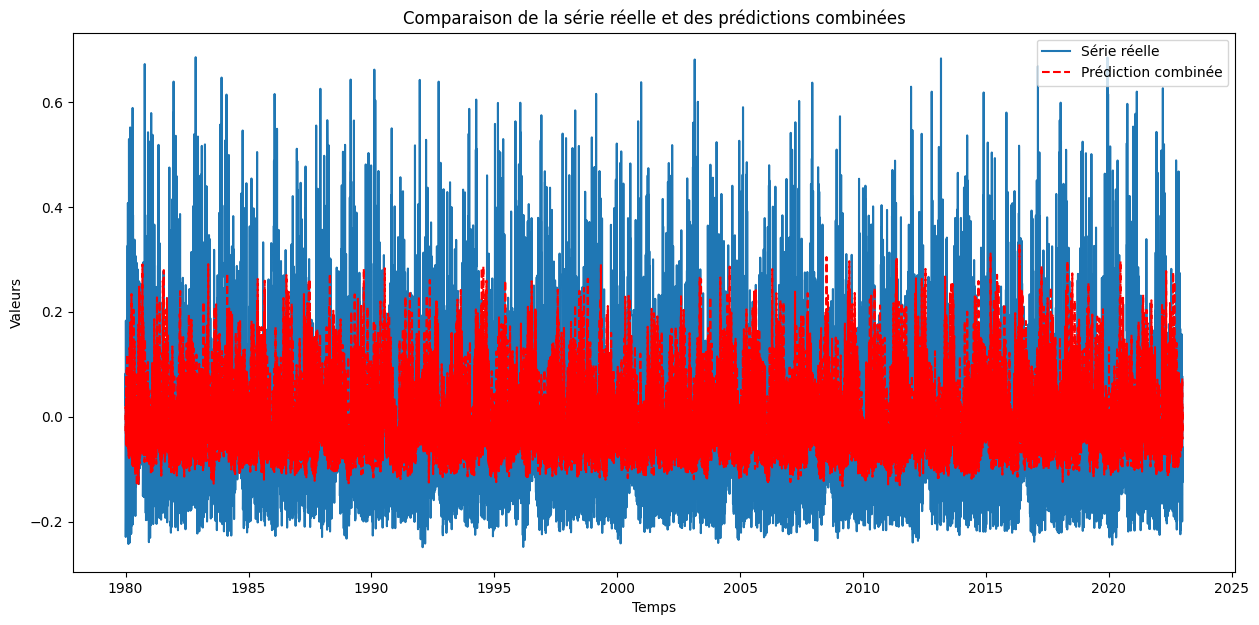

In [47]:
# Concaténation des prédictions en une seule série
pred_full = pd.concat([pred1, pred2, pred3, pred4, pred5])

# Vérification pour s'assurer que l'index de pred_full correspond à celui de la série originale
pred_full = pred_full.reindex(serie_.index)

# Affichage de la série originale et des prédictions combinées
plt.figure(figsize=(15, 7))
plt.plot(serie_, label='Série réelle')
plt.plot(pred_full, color='red', linestyle='--', label='Prédiction combinée')
plt.xlabel('Temps')
plt.ylabel('Valeurs')
plt.title('Comparaison de la série réelle et des prédictions combinées')
plt.legend()
plt.show()


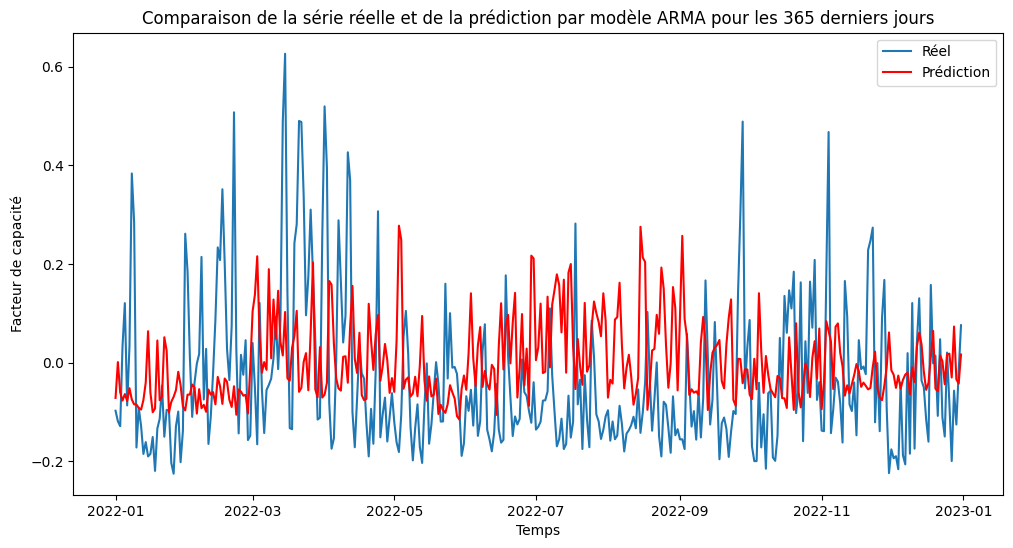

In [48]:
# Affichage sur la dernière année uniquement

# Sélection des 365 derniers jours pour chaque série
serie_derniere_annee = serie_[-365:]
pred_derniere_annee = pred_full[-365:]

# Création du graphique
plt.figure(figsize=(12,6))

# Affichage de la série réelle pour les 365 derniers jours
plt.plot(serie_derniere_annee, label="Réel")

# Affichage de la prédiction pour les 365 derniers jours
plt.plot(pred_derniere_annee, color = "r", label="Prédiction")

# Ajout des légendes et titres
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA pour les 365 derniers jours")
plt.legend()

# Affichage du graphique
plt.show()